Occupancy Detection based on ECO dataset: Summer
=======================================

In [1]:
import sys
import numpy as np
#sys.path.append("c:/python34/lib/site-packages")
import keras
import pandas as pd
from datetime import datetime as dt
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, Conv1D, MaxPooling2D, LSTM, Bidirectional
from keras import regularizers
import keras.callbacks as cb
from matplotlib import pyplot as plt
import random
import scipy.io as sio

Using TensorFlow backend.


The following function normalizes each column of the input array by substracting the mean and dividing by the standard deviation.

In [2]:
def normalize_data(X):
    for i in range(X.shape[1]):
        if np.std(X[:,i]) < 1e-4:
            den = 1e-4
        else:
            den = np.std(X[:,i])
        X[:,i] = (X[:,i]-np.mean(X[:,i]))/den
    return X

This class is used as a callback for the model fit function which is used to calculate and store the losses after each batch iteration.

In [3]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)


The following function plots the losses against the epochs.

In [4]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

The following function calculates the sad: 

In [5]:
def calc_sad(X):
    sad = 0
#     print(X)
#     print('end of X')
    for i in X.index.tolist():
#         print(i)
        if i < X.last_valid_index():
            sad += abs(X[i] - X[i+1])
    return sad

The following function detects the on-off status:

In [6]:
def detect_onoff(X):
    on_off = 0
    thA = 30
    thT = 30
    timecount = 0
    for i in X.index.tolist():
        if i < X.last_valid_index():
#             print(timecount)
            if abs(X[i] - X[i+1]) >= thA:
                timecount += 1
            else:
                timecount = 0
            if timecount == thT:
                on_off += 1
                timecount = 0
    return on_off

In [74]:
from sklearn.metrics import confusion_matrix
def conf_matrix(X_test,y_test,model):
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    # Using matshow here just because it sets the ticks up nicely. imshow is faster.
    im = ax.matshow(cm)
    fig.colorbar(im)

    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    plt.show()


In [7]:
from os import walk
path = "C:/Users/isisuser/Documents/Deep Learning_Purbodayv2/IE594964/REP594965/01_sm_csv/01"
f = []
for (dirpath, dirnames, filenames) in walk(path):
    f.extend(filenames)
    break

In [8]:
df={}
for filename in f:
    datestamp = filename[:-4].replace("-","")
    #print(datestamp)
    #if int(datestamp) >= 20120715 and int(datestamp) <= 20120825:
    df[datestamp]=pd.read_csv(path+"/"+filename,header=None,names=["powerallphases","powerl1","powerl2","powerl3","currentneutral","currentl1","currentl2",
                                    "currentl3","voltagel1","voltagel2","voltagel3","phaseanglevoltagel2l1",
                                    "phaseanglevoltagel3l1","phaseanglecurrentvoltagel1","phaseanglecurrentvoltagel2",
                                    "phaseanglecurrentvoltagel3"])
len(df)

245

In [9]:
df2 = pd.read_csv("C:/Users/isisuser/Documents/Deep Learning_Purbodayv2/IE594964/REP594965/01_occupancy_csv/01_summer.csv",index_col=0)
df2.index = pd.to_datetime(df2.index)
df2.index = df2.index.strftime('%Y%m%d')
len(df2)

39

In [10]:
import datetime
summer = df2.index.tolist()
df_summer = {}
for key in df.keys():
    if key in summer:
        df_summer[key]=df[key]
len(df_summer)
#df_summer["20120730"]

39

In [11]:
n = 900  #chunk row size
summer_features = pd.DataFrame()
for day, data in df_summer.items():
    list_df_summer = [data[i:i+n] for i in range(0,len(data),n)]
    mean123 = []
    mean1 = []
    mean2 = []
    mean3 = []
    std123 = []
    std1 = []
    std2 = []
    std3 = []
    sad1 = []
    sad2 = []
    sad3 = []
    sad123 = []
    range1 = []
    range2 = []
    range3 = []
    range123 = []
    max123 = []
    max1 = []
    max2 = []
    max3 = []
    min123 = []
    min1 = []
    min2 = []
    min3 = []
    corr123 = []
    corr1 = []
    corr2 = []
    corr3 = []
    onoff123 = []
    onoff1 = []
    onoff2 = []
    onoff3 = []
    
    for chunk in list_df_summer:
        mean123.append(np.mean(chunk['powerallphases']))
        mean1.append(np.mean(chunk['powerl1']))
        mean2.append(np.mean(chunk['powerl2']))
        mean3.append(np.mean(chunk['powerl3']))
        std123.append(np.std(chunk['powerallphases']))
        std1.append(np.std(chunk['powerl1']))
        std2.append(np.std(chunk['powerl2']))
        std3.append(np.std(chunk['powerl3']))
        range123.append(np.amax(chunk['powerallphases'] - np.amin(chunk['powerallphases'])))
        range1.append(np.amax(chunk['powerl1'] - np.amin(chunk['powerl1'])))
        range2.append(np.amax(chunk['powerl2'] - np.amin(chunk['powerl2'])))
        range3.append(np.amax(chunk['powerl3'] - np.amin(chunk['powerl3'])))
        sad123.append(calc_sad(chunk['powerallphases']))
        sad1.append(calc_sad(chunk['powerl1']))
        sad2.append(calc_sad(chunk['powerl2']))
        sad3.append(calc_sad(chunk['powerl3']))
        max123.append(np.amax(chunk['powerallphases']))
        max1.append(np.amax(chunk['powerl1']))
        max2.append(np.amax(chunk['powerl2']))
        max3.append(np.amax(chunk['powerl3']))
        min123.append(np.amin(chunk['powerallphases']))
        min1.append(np.amin(chunk['powerl1']))
        min2.append(np.amin(chunk['powerl2']))
        min3.append(np.amin(chunk['powerl3']))
        corr123.append(chunk['powerallphases'].autocorr(lag=1))
        corr1.append(chunk['powerl1'].autocorr(lag=1))
        corr2.append(chunk['powerl2'].autocorr(lag=1))
        corr3.append(chunk['powerl3'].autocorr(lag=1))
        onoff123.append(detect_onoff(chunk['powerallphases']))
        onoff1.append(detect_onoff(chunk['powerl1']))
        onoff2.append(detect_onoff(chunk['powerl2']))
        onoff3.append(detect_onoff(chunk['powerl3']))
    ptime = list(range(1,97))
    data = pd.DataFrame(np.column_stack((min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,mean3,mean123,
                                            std1,std2,std3,std123,sad1,sad2,sad3,sad123,
                                         corr1,corr2,corr3,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,
                                         range3,range123,ptime)), 
                            columns = ['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])
    
    
    summer_features = summer_features.append(data)
summer_features.loc[summer_features.ptime < 25, 'ptime'] = 0
summer_features.loc[summer_features.ptime > 89, 'ptime'] = 0
summer_features = summer_features.loc[(summer_features['ptime'] >0)]
summer_features['ptime'] = summer_features['ptime'] - 24

summer_features

,min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,...,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,range3,range123,ptime
24,24.541,67.500,9.315,132.982,103.091,129.301,71.862,244.994,57.775494,76.168270,...,0.974188,0.0,0.0,0.0,0.0,78.550,61.801,62.547,112.012,1.0
25,24.394,64.997,9.377,115.815,116.655,1411.660,72.407,1476.630,56.177676,244.087143,...,0.992230,0.0,0.0,0.0,0.0,92.261,1346.663,63.030,1360.815,2.0
26,24.440,34.284,9.181,68.577,25.195,1362.910,10.214,1397.610,24.790351,253.476867,...,0.980321,0.0,0.0,0.0,0.0,0.755,1328.626,1.033,1329.033,3.0
27,24.500,33.878,9.176,68.723,78.227,1324.660,10.851,1390.120,57.066767,93.425890,...,0.978886,0.0,0.0,0.0,0.0,53.727,1290.782,1.675,1321.397,4.0
28,24.379,33.719,9.243,67.799,62.065,34.772,10.128,106.200,45.192284,34.198749,...,0.998727,0.0,0.0,0.0,0.0,37.686,1.053,0.885,38.401,5.0
29,24.513,33.709,9.286,67.957,98.191,95.408,10.152,162.016,27.716543,35.430220,...,0.982954,0.0,0.0,0.0,0.0,73.678,61.699,0.866,94.059,6.0
30,55.175,33.588,9.219,98.626,57.584,119.937,10.305,187.091,56.220909,40.932154,...,0.992854,0.0,0.0,0.0,0.0,2.409,86.349,1.086,88.465,7.0
31,24.532,33.656,9.229,98.555,55.756,84.390,10.243,149.174,43.084998,74.511177,...,0.995619,0.0,0.0,0.0,0.0,31.224,50.734,1.014,50.619,8.0
32,24.728,76.543,8.918,111.544,91.713,803.033,10.219,838.116,29.132812,132.700551,...,0.755625,0.0,0.0,0.0,0.0,66.985,726.490,1.301,726.572,9.0
33,55.294,125.730,8.836,191.223,57.831,136.099,71.398,255.654,56.274994,129.458838,...,0.997407,0.0,0.0,0.0,0.0,2.537,10.369,62.562,64.431,10.0


In [12]:
n = 900

cuml_list = []
for index,row in df2.iterrows():
    occ_summer = []
    list_oc_summer = [row[i:i+n] for i in range(0,len(row),n)]
    for chunk in list_oc_summer:
        occ_summer.append(np.bincount(chunk).argmax())
    occ_summer = occ_summer[24:89]
#     print(len(occ_summer))
    cuml_list.extend(occ_summer)
#     print(len(cuml_list))
occ_summer_data = pd.DataFrame(cuml_list, columns = ['occupancy'])
print(occ_summer_data)  
    

      occupancy
0             1
1             1
2             1
3             1
4             1
5             1
6             1
7             1
8             1
9             1
10            1
11            1
12            1
13            1
14            1
15            1
16            1
17            1
18            1
19            1
20            1
21            1
22            1
23            1
24            1
25            0
26            0
27            0
28            0
29            0
...         ...
2505          1
2506          1
2507          1
2508          1
2509          1
2510          1
2511          1
2512          1
2513          1
2514          1
2515          1
2516          1
2517          1
2518          1
2519          1
2520          1
2521          1
2522          1
2523          1
2524          1
2525          1
2526          1
2527          1
2528          1
2529          1
2530          1
2531          1
2532          1
2533          1
2534          1

[2535 r

Replacing all the 'nan' values by '0'

In [13]:
summer_features[np.isnan(summer_features)] = 0

Model with Manual Validation:
-----------

In [14]:
def init_model(features):
    model = Sequential()
    model.add(Conv1D(256, 4, activation="relu",
                    input_shape=(features,1), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(128, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(64, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid',kernel_initializer="he_uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
    return model

Data Pre-processing:


In [15]:
X = np.array(summer_features)
print('X dim: ',X.shape)
y = np.array(occ_summer_data)
print('y dim: ',y.shape)

X = normalize_data(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('X_train dim: ', X_train.shape)
print('X_tesy dim: ', X_test.shape)
print('y_train dim: ', y_train.shape)
print('y_tesy dim: ', y_test.shape)

X dim:  (2535, 33)
y dim:  (2535, 1)
X_train dim:  (2154, 33, 1)
X_tesy dim:  (381, 33, 1)
y_train dim:  (2154, 1)
y_tesy dim:  (381, 1)


In [16]:
features = X_train.shape[1]
model = init_model(features)
model.summary()

W0828 14:49:29.160645  3952 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 14:49:29.180646  3952 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 14:49:29.183646  3952 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 14:49:29.255650  3952 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0828 14:49:29.273652  3952 deprec

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 33, 256)           1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 33, 256)           1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 33, 128)           131200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 33, 128)           512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 33, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 33, 64)            32832     
__________

Training and Testing:


Train on 2154 samples, validate on 381 samples
Epoch 1/150
 - 4s - loss: 0.6630 - acc: 0.6773 - val_loss: 0.5836 - val_acc: 0.7717
Epoch 2/150
 - 2s - loss: 0.5050 - acc: 0.7748 - val_loss: 0.4367 - val_acc: 0.7927
Epoch 3/150
 - 2s - loss: 0.4620 - acc: 0.7957 - val_loss: 0.4459 - val_acc: 0.8005
Epoch 4/150
 - 2s - loss: 0.4443 - acc: 0.7920 - val_loss: 0.4165 - val_acc: 0.8136
Epoch 5/150
 - 2s - loss: 0.4353 - acc: 0.7971 - val_loss: 0.4660 - val_acc: 0.8268
Epoch 6/150
 - 2s - loss: 0.4162 - acc: 0.8148 - val_loss: 0.3852 - val_acc: 0.8163
Epoch 7/150
 - 2s - loss: 0.3940 - acc: 0.8171 - val_loss: 0.3905 - val_acc: 0.8110
Epoch 8/150
 - 2s - loss: 0.4044 - acc: 0.8120 - val_loss: 0.3781 - val_acc: 0.8031
Epoch 9/150
 - 2s - loss: 0.3992 - acc: 0.8143 - val_loss: 0.3647 - val_acc: 0.8241
Epoch 10/150
 - 2s - loss: 0.3930 - acc: 0.8078 - val_loss: 0.3476 - val_acc: 0.8268
Epoch 11/150
 - 2s - loss: 0.3806 - acc: 0.8171 - val_loss: 0.3625 - val_acc: 0.8215
Epoch 12/150
 - 2s - loss: 

Epoch 97/150
 - 2s - loss: 0.2548 - acc: 0.8890 - val_loss: 0.3704 - val_acc: 0.8504
Epoch 98/150
 - 2s - loss: 0.2581 - acc: 0.8867 - val_loss: 0.3625 - val_acc: 0.8451
Epoch 99/150
 - 2s - loss: 0.2700 - acc: 0.8835 - val_loss: 0.3532 - val_acc: 0.8478
Epoch 100/150
 - 2s - loss: 0.2481 - acc: 0.8904 - val_loss: 0.3569 - val_acc: 0.8425
Epoch 101/150
 - 2s - loss: 0.2617 - acc: 0.8858 - val_loss: 0.3631 - val_acc: 0.8583
Epoch 102/150
 - 2s - loss: 0.2628 - acc: 0.8825 - val_loss: 0.3761 - val_acc: 0.8346
Epoch 103/150
 - 2s - loss: 0.2527 - acc: 0.8858 - val_loss: 0.3536 - val_acc: 0.8635
Epoch 104/150
 - 2s - loss: 0.2554 - acc: 0.8853 - val_loss: 0.3551 - val_acc: 0.8530
Epoch 105/150
 - 2s - loss: 0.2535 - acc: 0.8867 - val_loss: 0.3497 - val_acc: 0.8556
Epoch 106/150
 - 2s - loss: 0.2568 - acc: 0.8844 - val_loss: 0.3497 - val_acc: 0.8556
Epoch 107/150
 - 2s - loss: 0.2608 - acc: 0.8890 - val_loss: 0.3571 - val_acc: 0.8399
Epoch 108/150
 - 2s - loss: 0.2498 - acc: 0.8909 - val_lo

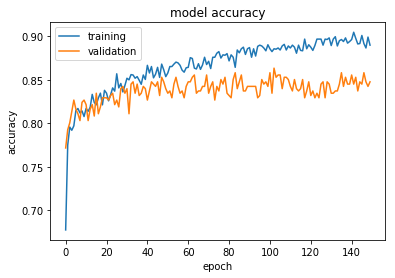

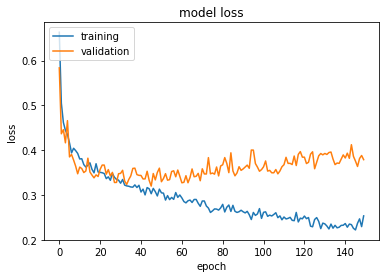

In [17]:
history = LossHistory()
hiss = model.fit(X_train, y_train, epochs=150, batch_size=32,
                callbacks=[history],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=32)
print('loss and accuracy:: ',score)

plt.plot(hiss.history['acc'])
plt.plot(hiss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss.history['loss'])
plt.plot(hiss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

Confusion Matrix:

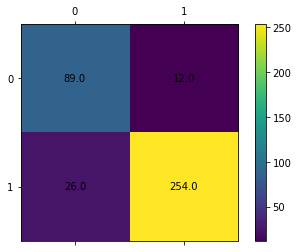

In [29]:
from sklearn.metrics import confusion_matrix
def conf_matrix(X_test,y_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    # Using matshow here just because it sets the ticks up nicely. imshow is faster.
    im = ax.matshow(cm)
    fig.colorbar(im)

    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    plt.show()

conf_matrix(X_test,y_test)

Classification error: 84.78

Early Stopping:
------

In [34]:
model = init_model(features)

Training and Testing:


Train on 2154 samples, validate on 381 samples
Epoch 1/150
 - 7s - loss: 0.6773 - acc: 0.6787 - val_loss: 0.6660 - val_acc: 0.7165
Epoch 2/150
 - 3s - loss: 0.5318 - acc: 0.7586 - val_loss: 0.4953 - val_acc: 0.7874
Epoch 3/150
 - 3s - loss: 0.4861 - acc: 0.7790 - val_loss: 0.5245 - val_acc: 0.7717
Epoch 4/150
 - 3s - loss: 0.4543 - acc: 0.7916 - val_loss: 0.4042 - val_acc: 0.8110
Epoch 5/150
 - 3s - loss: 0.4366 - acc: 0.7953 - val_loss: 0.4222 - val_acc: 0.8031
Epoch 6/150
 - 3s - loss: 0.4258 - acc: 0.7939 - val_loss: 0.4032 - val_acc: 0.8084
Epoch 7/150
 - 3s - loss: 0.4016 - acc: 0.8143 - val_loss: 0.3660 - val_acc: 0.8215
Epoch 8/150
 - 3s - loss: 0.3956 - acc: 0.8101 - val_loss: 0.3867 - val_acc: 0.7979
Epoch 9/150
 - 3s - loss: 0.3865 - acc: 0.8143 - val_loss: 0.3543 - val_acc: 0.8268
Epoch 10/150
 - 3s - loss: 0.3955 - acc: 0.8194 - val_loss: 0.3678 - val_acc: 0.8084
Epoch 11/150
 - 3s - loss: 0.3825 - acc: 0.8171 - val_loss: 0.3592 - val_acc: 0.8110
Epoch 12/150
 - 3s - loss: 

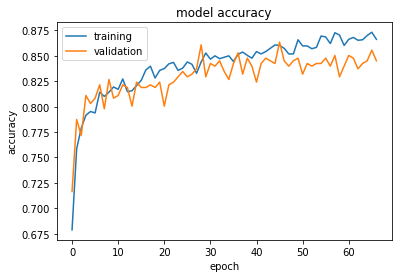

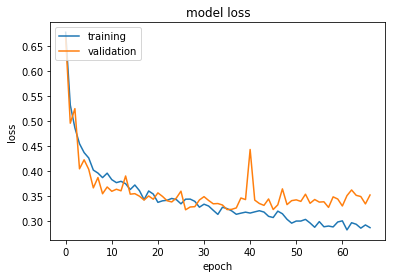

In [35]:
history = LossHistory()
es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss = model.fit(X_train, y_train, epochs=150, batch_size=32,
                callbacks=[history,es],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=32)
print('loss and accuracy:: ',score)

plt.plot(hiss.history['acc'])
plt.plot(hiss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss.history['loss'])
plt.plot(hiss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

Confusion Matrix:

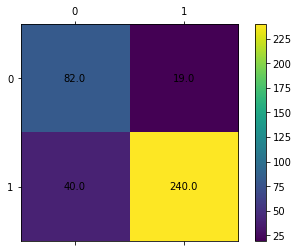

In [36]:
conf_matrix(X_test,y_test,model)

Model with K-fold Validation:
----------

acc: 83.47%


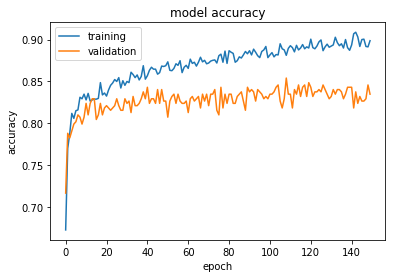

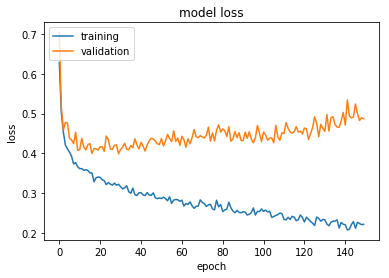

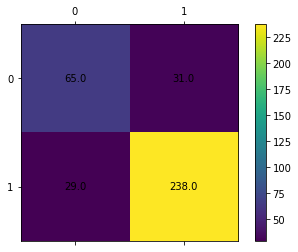

acc: 85.91%


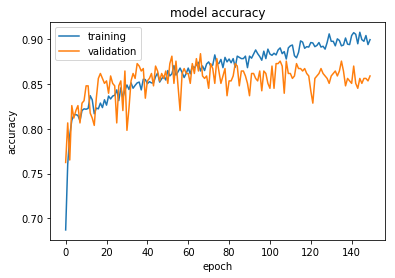

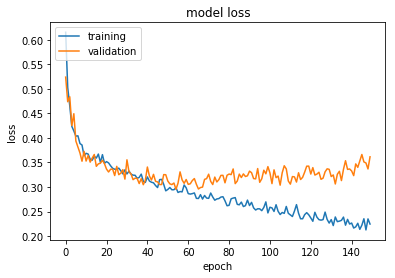

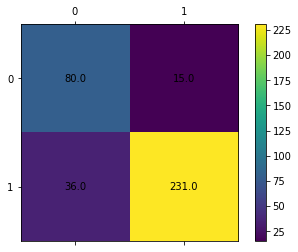

acc: 82.87%


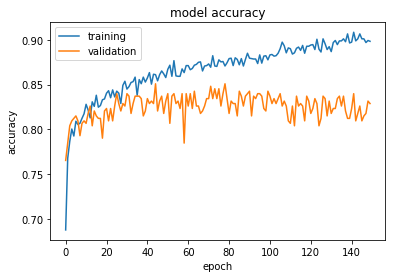

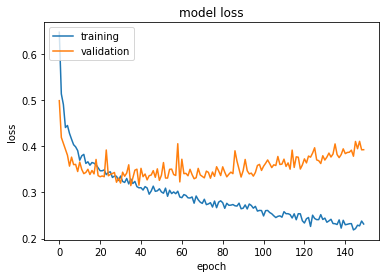

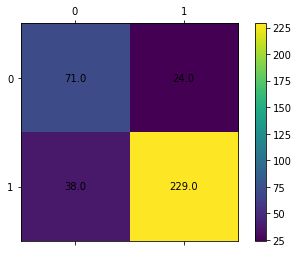

acc: 85.64%


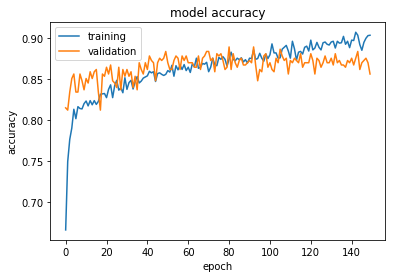

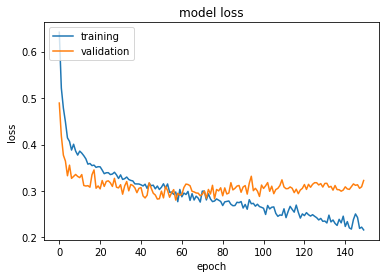

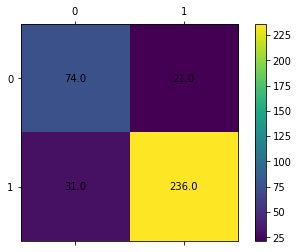

acc: 84.53%


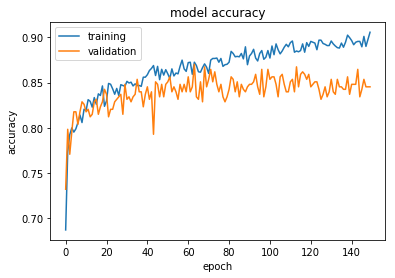

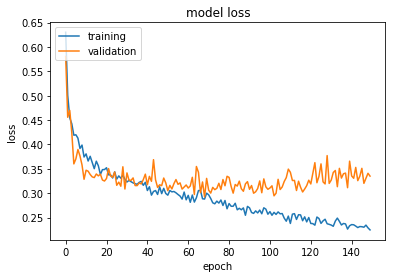

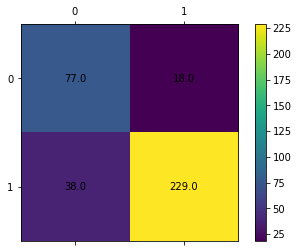

acc: 84.81%


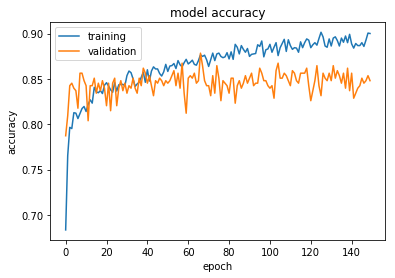

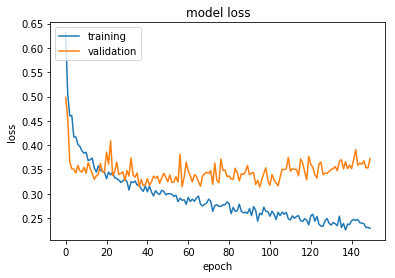

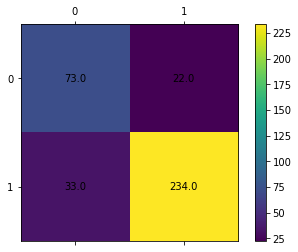

acc: 88.12%


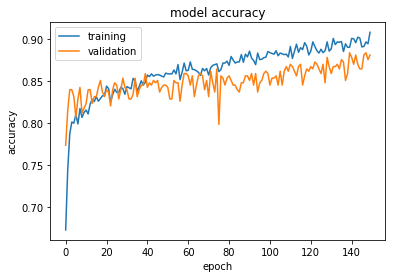

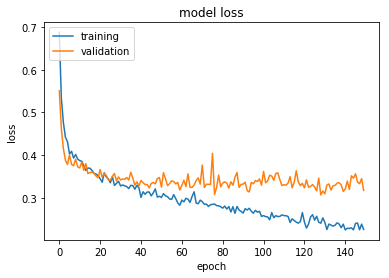

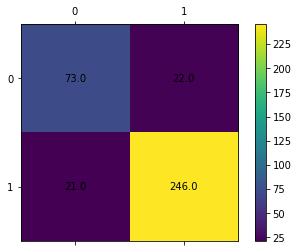

NameError: name 'numpy' is not defined

In [30]:
from sklearn.model_selection import StratifiedKFold
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
loss = []
for train, test in kfold.split(X, y):
    
    model = init_model(features)
    
    X_train_k =X[train].reshape(X[train].shape[0], X[train].shape[1], 1)
    X_test_k = X[test].reshape(X[test].shape[0], X[test].shape[1], 1)
    history = LossHistory()
    hiss = model.fit(X_train_k, y[train], epochs=150, batch_size=32,
                callbacks=[history],
                validation_data=(X_test_k,y[test]), verbose=0)
    scores = model.evaluate(X_test_k, y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    loss.append(scores[0])
#     print(score)
    plt.plot(hiss.history['acc'])
    plt.plot(hiss.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(hiss.history['loss'])
    plt.plot(hiss.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    conf_matrix(X_test_k,y[test])


In [33]:
print('accuracy:: ',"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print('error::', "%.2f (+/- %.2f)" % (np.mean(loss), np.std(loss)))

accuracy::  85.05% (+/- 1.61%)
error:: 0.37 (+/- 0.05)


Shapely Values:
-------

In [41]:
import shap

# select a set of background examples to take an expectation over
background = X_train
X_train.shape

(2154, 33, 1)

In [42]:
model = init_model(features)
# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
shap_values = e.shap_values(X_train)

In [47]:
shap_values[0]= shap_values[0].reshape(shap_values[0].shape[0],shap_values[0].shape[1])
shap_values[0].shape

X_postprocess = X_train.reshape(X_train.shape[0],X_train.shape[1])
X_postprocess.shape

(2154, 33)

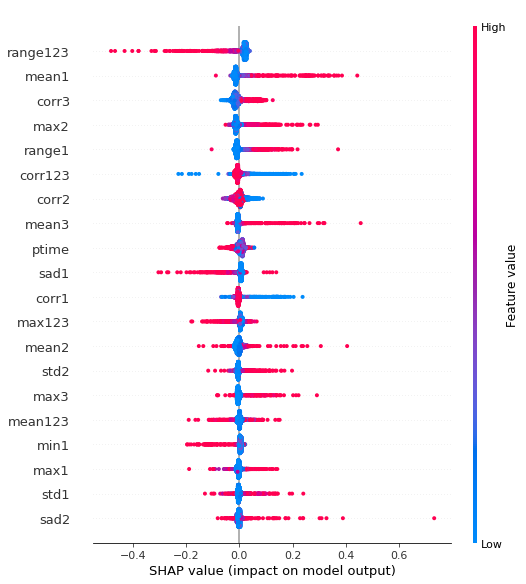

In [48]:
shap.summary_plot(shap_values[0], X_postprocess, feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

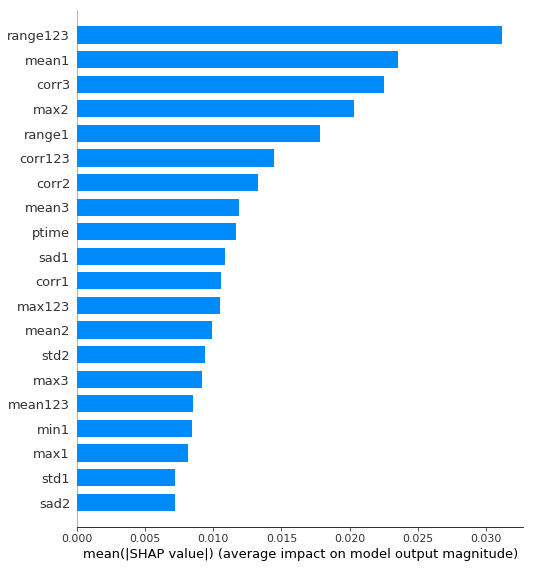

In [49]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar", feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

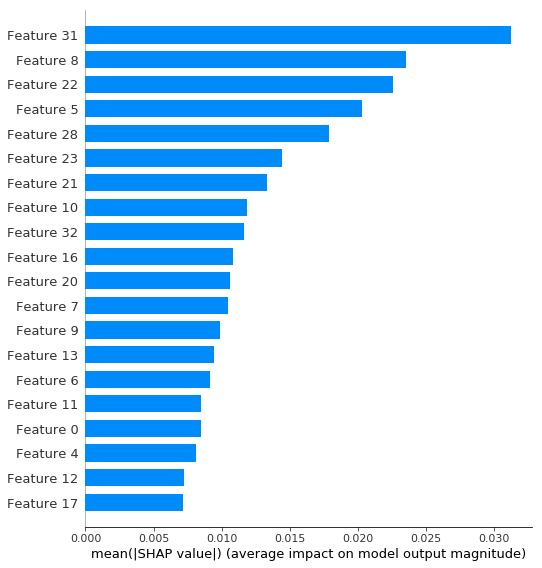

In [50]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar")

After Feature Reduction by Shapely Values
-------------

In [61]:
new_summer_features = np.concatenate((X[:,0][:, np.newaxis],X[:,4:14], X[:,16:18],X[:,20:24],X[:,28][:, np.newaxis],X[:,31:33]),axis=1)
new_summer_features.shape

(2535, 20)

In [71]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(new_summer_features, y, test_size=0.15, shuffle=True)

X_train_s = X_train_s.reshape(X_train_s.shape[0], X_train_s.shape[1], 1)
X_test_s = X_test_s.reshape(X_test_s.shape[0], X_test_s.shape[1], 1)

print('X_train dim: ', X_train_s.shape)
print('X_tesy dim: ', X_test_s.shape)
print('y_train dim: ', y_train_s.shape)
print('y_tesy dim: ', y_test_s.shape)

X_train dim:  (2154, 20, 1)
X_tesy dim:  (381, 20, 1)
y_train dim:  (2154, 1)
y_tesy dim:  (381, 1)


In [72]:
features_s = 20
model = init_model(features_s)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 20, 256)           1280      
_________________________________________________________________
batch_normalization_109 (Bat (None, 20, 256)           1024      
_________________________________________________________________
dropout_109 (Dropout)        (None, 20, 256)           0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 20, 128)           131200    
_________________________________________________________________
batch_normalization_110 (Bat (None, 20, 128)           512       
_________________________________________________________________
dropout_110 (Dropout)        (None, 20, 128)           0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 20, 64)            32832     
__________

Train on 2154 samples, validate on 381 samples
Epoch 1/150
 - 6s - loss: 0.6903 - acc: 0.6565 - val_loss: 0.4941 - val_acc: 0.7874
Epoch 2/150
 - 2s - loss: 0.5311 - acc: 0.7382 - val_loss: 0.4415 - val_acc: 0.7795
Epoch 3/150
 - 2s - loss: 0.4751 - acc: 0.7744 - val_loss: 0.4006 - val_acc: 0.8058
Epoch 4/150
 - 2s - loss: 0.4456 - acc: 0.8032 - val_loss: 0.4700 - val_acc: 0.8110
Epoch 5/150
 - 2s - loss: 0.4231 - acc: 0.7990 - val_loss: 0.4055 - val_acc: 0.8110
Epoch 6/150
 - 2s - loss: 0.4458 - acc: 0.7846 - val_loss: 0.3966 - val_acc: 0.8215
Epoch 7/150
 - 2s - loss: 0.4022 - acc: 0.7981 - val_loss: 0.3783 - val_acc: 0.8215
Epoch 8/150
 - 2s - loss: 0.3999 - acc: 0.8106 - val_loss: 0.3745 - val_acc: 0.8294
Epoch 9/150
 - 2s - loss: 0.3894 - acc: 0.8027 - val_loss: 0.3736 - val_acc: 0.8399
Epoch 10/150
 - 2s - loss: 0.3881 - acc: 0.8180 - val_loss: 0.3802 - val_acc: 0.8294
Epoch 11/150
 - 2s - loss: 0.3816 - acc: 0.8157 - val_loss: 0.3823 - val_acc: 0.8189
Epoch 12/150
 - 2s - loss: 

Epoch 97/150
 - 3s - loss: 0.2658 - acc: 0.8784 - val_loss: 0.3711 - val_acc: 0.8530
Epoch 98/150
 - 4s - loss: 0.2684 - acc: 0.8784 - val_loss: 0.3793 - val_acc: 0.8425
Epoch 99/150
 - 4s - loss: 0.2641 - acc: 0.8784 - val_loss: 0.4250 - val_acc: 0.8504
Epoch 100/150
 - 4s - loss: 0.2681 - acc: 0.8784 - val_loss: 0.4002 - val_acc: 0.8478
Epoch 101/150
 - 4s - loss: 0.2526 - acc: 0.8839 - val_loss: 0.4201 - val_acc: 0.8346
Epoch 102/150
 - 4s - loss: 0.2657 - acc: 0.8747 - val_loss: 0.4003 - val_acc: 0.8504
Epoch 103/150
 - 4s - loss: 0.2686 - acc: 0.8756 - val_loss: 0.4175 - val_acc: 0.8320
Epoch 104/150
 - 4s - loss: 0.2594 - acc: 0.8793 - val_loss: 0.3807 - val_acc: 0.8478
Epoch 105/150
 - 4s - loss: 0.2689 - acc: 0.8770 - val_loss: 0.3891 - val_acc: 0.8425
Epoch 106/150
 - 4s - loss: 0.2611 - acc: 0.8798 - val_loss: 0.4030 - val_acc: 0.8425
Epoch 107/150
 - 4s - loss: 0.2662 - acc: 0.8821 - val_loss: 0.3905 - val_acc: 0.8373
Epoch 108/150
 - 4s - loss: 0.2620 - acc: 0.8839 - val_lo

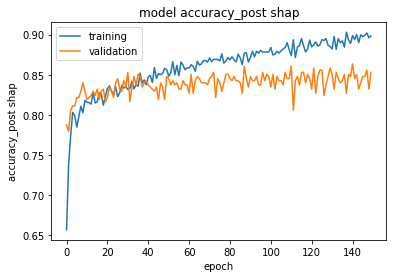

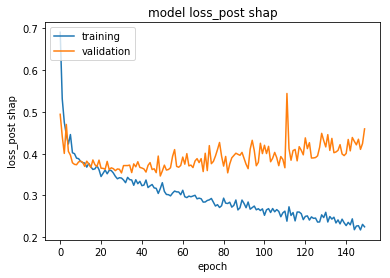

In [73]:
history_s = LossHistory()
hiss_s = model.fit(X_train_s, y_train_s, epochs=150, batch_size=32,
                callbacks=[history_s],
                validation_data=(X_test_s,y_test_s), verbose=2)
score_s = model.evaluate(X_test_s,y_test_s, batch_size=32)
print(score_s)
plt.plot(hiss_s.history['acc'])
plt.plot(hiss_s.history['val_acc'])
plt.title('model accuracy_post shap')
plt.ylabel('accuracy_post shap')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss_s.history['loss'])
plt.plot(hiss_s.history['val_loss'])
plt.title('model loss_post shap')
plt.ylabel('loss_post shap')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

y_pred = model.predict(X_test_s)

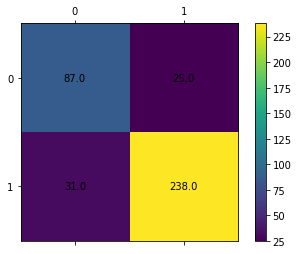

In [75]:
conf_matrix(X_test_s,y_test_s,model)

Early Stopping:
------

In [76]:
model = init_model(features_s)

Training and Testing:


Train on 2154 samples, validate on 381 samples
Epoch 1/150
 - 17s - loss: 0.6525 - acc: 0.6648 - val_loss: 0.4996 - val_acc: 0.7900
Epoch 2/150
 - 4s - loss: 0.5210 - acc: 0.7479 - val_loss: 0.4467 - val_acc: 0.8136
Epoch 3/150
 - 4s - loss: 0.4757 - acc: 0.7767 - val_loss: 0.4228 - val_acc: 0.7927
Epoch 4/150
 - 4s - loss: 0.4300 - acc: 0.7906 - val_loss: 0.4041 - val_acc: 0.8058
Epoch 5/150
 - 4s - loss: 0.4304 - acc: 0.7948 - val_loss: 0.3717 - val_acc: 0.8425
Epoch 6/150
 - 4s - loss: 0.4090 - acc: 0.8032 - val_loss: 0.3785 - val_acc: 0.8346
Epoch 7/150
 - 4s - loss: 0.4119 - acc: 0.7925 - val_loss: 0.3779 - val_acc: 0.8163
Epoch 8/150
 - 4s - loss: 0.4018 - acc: 0.8073 - val_loss: 0.3880 - val_acc: 0.7979
Epoch 9/150
 - 4s - loss: 0.3932 - acc: 0.8106 - val_loss: 0.3677 - val_acc: 0.8399
Epoch 10/150
 - 4s - loss: 0.3861 - acc: 0.8106 - val_loss: 0.3725 - val_acc: 0.8373
Epoch 11/150
 - 4s - loss: 0.3789 - acc: 0.8143 - val_loss: 0.3716 - val_acc: 0.8268
Epoch 12/150
 - 4s - loss:

Epoch 97/150
 - 3s - loss: 0.2558 - acc: 0.8770 - val_loss: 0.4041 - val_acc: 0.8399
Epoch 98/150
 - 3s - loss: 0.2574 - acc: 0.8835 - val_loss: 0.4047 - val_acc: 0.8530
Epoch 99/150
 - 3s - loss: 0.2579 - acc: 0.8858 - val_loss: 0.3756 - val_acc: 0.8478
Epoch 100/150
 - 3s - loss: 0.2628 - acc: 0.8849 - val_loss: 0.4025 - val_acc: 0.8425
Epoch 101/150
 - 4s - loss: 0.2754 - acc: 0.8779 - val_loss: 0.3559 - val_acc: 0.8556
Epoch 102/150
 - 3s - loss: 0.2610 - acc: 0.8867 - val_loss: 0.3947 - val_acc: 0.8530
Epoch 103/150
 - 3s - loss: 0.2627 - acc: 0.8798 - val_loss: 0.3771 - val_acc: 0.8609
Epoch 00103: early stopping
381/381 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 512us/step
loss and accuracy::  [0.3771176452398926, 0.8608923904851978]


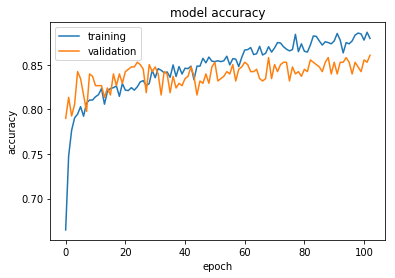

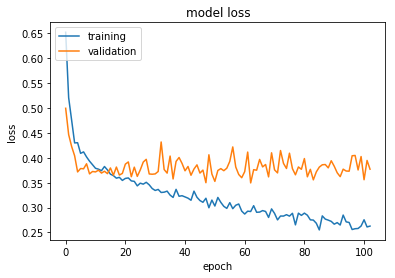

In [77]:
history_se = LossHistory()
es_se = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss_se = model.fit(X_train_s, y_train_s, epochs=150, batch_size=32,
                callbacks=[history,es_se],
                validation_data=(X_test_s,y_test_s), verbose=2)
score_se = model.evaluate(X_test_s, y_test_s, batch_size=32)
print('loss and accuracy:: ',score_se)

plt.plot(hiss_se.history['acc'])
plt.plot(hiss_se.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss_se.history['loss'])
plt.plot(hiss_se.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

Confusion Matrix:

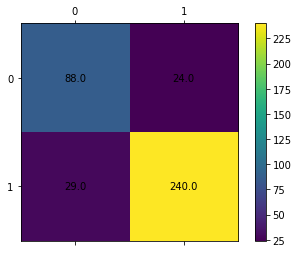

In [78]:
conf_matrix(X_test_s,y_test_s,model)

Model with K-fold Validation:
----------

Epoch 00049: early stopping
acc: 83.47%


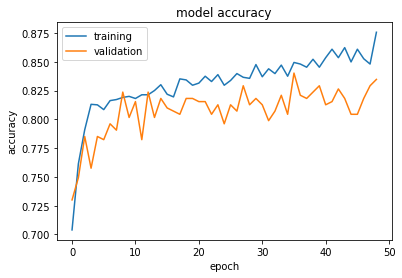

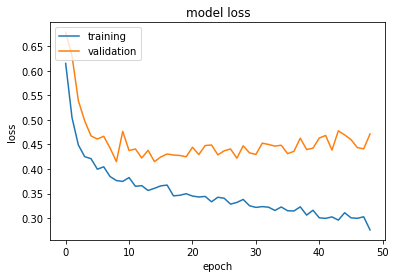

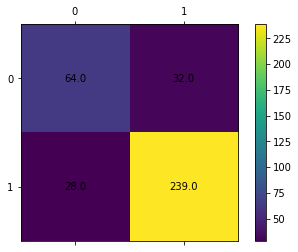

Epoch 00096: early stopping
acc: 85.08%


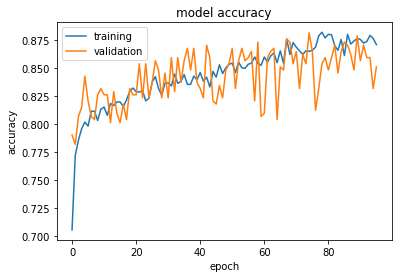

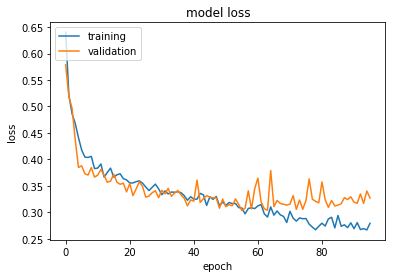

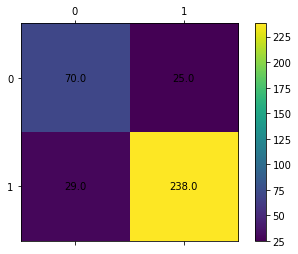

Epoch 00099: early stopping
acc: 84.53%


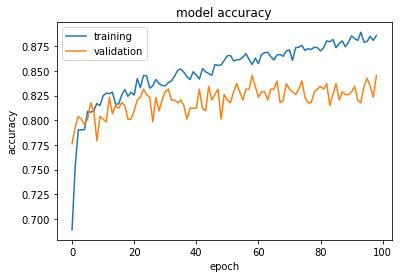

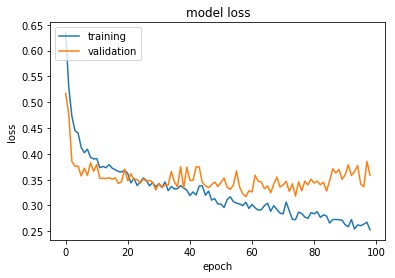

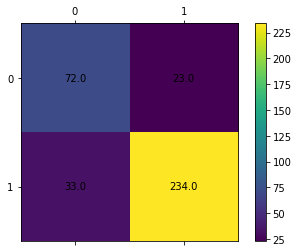

Epoch 00107: early stopping
acc: 86.46%


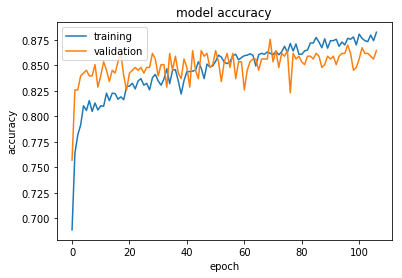

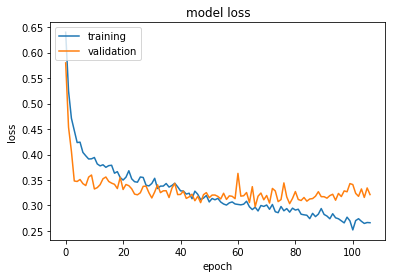

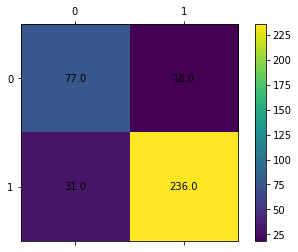

Epoch 00118: early stopping
acc: 84.53%


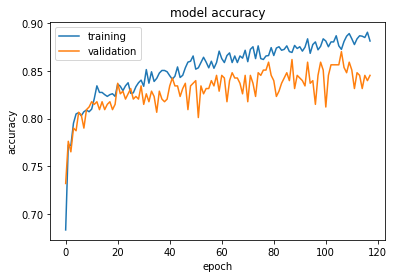

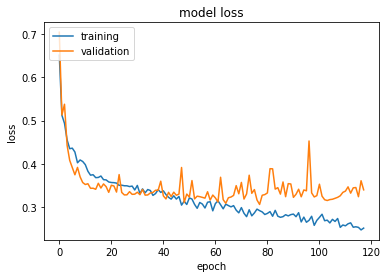

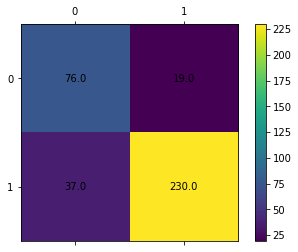

Epoch 00105: early stopping
acc: 83.70%


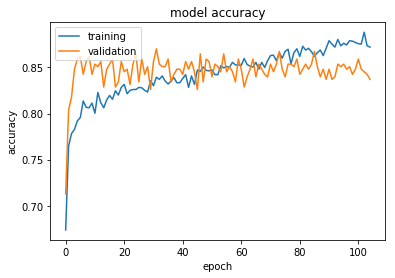

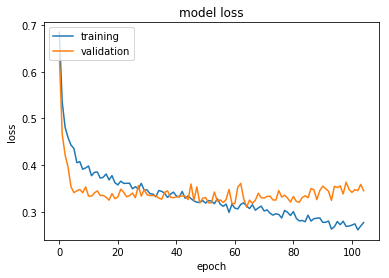

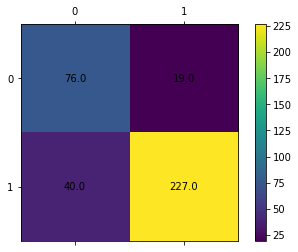

Epoch 00140: early stopping
acc: 84.81%


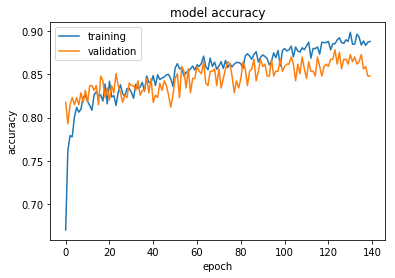

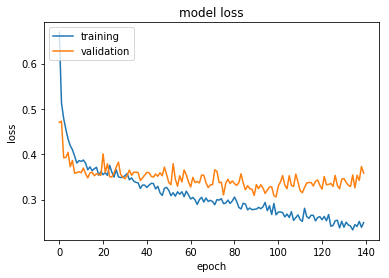

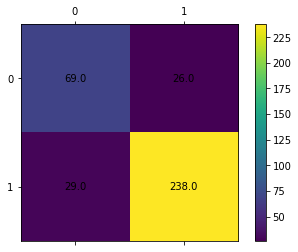

In [80]:
from sklearn.model_selection import StratifiedKFold
seed = 7
kfold_s = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores_s = []
loss_s = []
XX = new_summer_features
for train, test in kfold_s.split(XX, y):
    
    model = init_model(features_s)
    
    X_train_ks =XX[train].reshape(XX[train].shape[0], XX[train].shape[1], 1)
    X_test_ks = XX[test].reshape(XX[test].shape[0], XX[test].shape[1], 1)
    history_ks = LossHistory()
    es_ks = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
    hiss_ks = model.fit(X_train_ks, y[train], epochs=150, batch_size=32,
                callbacks=[history_ks,es_ks],
                validation_data=(X_test_ks,y[test]), verbose=0)
    scores_ks = model.evaluate(X_test_ks, y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores_ks[1]*100))
    cvscores_s.append(scores_ks[1] * 100)
    loss_s.append(scores_ks[0])
#     print(score)
    plt.plot(hiss_ks.history['acc'])
    plt.plot(hiss_ks.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(hiss_ks.history['loss'])
    plt.plot(hiss_ks.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    conf_matrix(X_test_ks,y[test],model)


In [81]:
print('accuracy:: ',"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_s), np.std(cvscores_s)))
print('error::', "%.2f (+/- %.2f)" % (np.mean(loss_s), np.std(loss_s)))

accuracy::  84.66% (+/- 0.91%)
error:: 0.36 (+/- 0.05)


PCA:
-------

In [82]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.99)

In [83]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [84]:
pca.n_components_

18

In [85]:
summer_pca = pca.transform(X)

In [86]:
summer_pca.shape

(2535, 18)

In [87]:
from sklearn.model_selection import train_test_split
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(summer_pca, y, test_size=0.15, shuffle=True)

In [89]:
X_train_p.shape

(2154, 18)

Early Stopping:
------

In [94]:
features_p = X_train_p.shape[1]
model = init_model(features_p)

X_train_p = X_train_p.reshape(X_train_p.shape[0], X_train_p.shape[1], 1)
X_test_p = X_test_p.reshape(X_test_p.shape[0], X_test_p.shape[1], 1)

print('X_train dim: ', X_train_p.shape)
print('X_tesy dim: ', X_test_p.shape)
print('y_train dim: ', y_train_p.shape)
print('y_tesy dim: ', y_test_p.shape)

X_train dim:  (2154, 18, 1)
X_tesy dim:  (381, 18, 1)
y_train dim:  (2154, 1)
y_tesy dim:  (381, 1)


Training and Testing:


Train on 2154 samples, validate on 381 samples
Epoch 1/150
 - 9s - loss: 0.6481 - acc: 0.6560 - val_loss: 0.5315 - val_acc: 0.7507
Epoch 2/150
 - 2s - loss: 0.5209 - acc: 0.7386 - val_loss: 0.4883 - val_acc: 0.8136
Epoch 3/150
 - 2s - loss: 0.4735 - acc: 0.7762 - val_loss: 0.4272 - val_acc: 0.8373
Epoch 4/150
 - 2s - loss: 0.4415 - acc: 0.7939 - val_loss: 0.3908 - val_acc: 0.8478
Epoch 5/150
 - 2s - loss: 0.4273 - acc: 0.8022 - val_loss: 0.3846 - val_acc: 0.8268
Epoch 6/150
 - 2s - loss: 0.4153 - acc: 0.8083 - val_loss: 0.3788 - val_acc: 0.8346
Epoch 7/150
 - 2s - loss: 0.4028 - acc: 0.8092 - val_loss: 0.3716 - val_acc: 0.8320
Epoch 8/150
 - 2s - loss: 0.4020 - acc: 0.8106 - val_loss: 0.3718 - val_acc: 0.8294
Epoch 9/150
 - 2s - loss: 0.3882 - acc: 0.8157 - val_loss: 0.3684 - val_acc: 0.8478
Epoch 10/150
 - 2s - loss: 0.3883 - acc: 0.8097 - val_loss: 0.3715 - val_acc: 0.8425
Epoch 11/150
 - 2s - loss: 0.3886 - acc: 0.8213 - val_loss: 0.3738 - val_acc: 0.8294
Epoch 12/150
 - 2s - loss: 

Epoch 97/150
 - 2s - loss: 0.2758 - acc: 0.8714 - val_loss: 0.3408 - val_acc: 0.8399
Epoch 98/150
 - 2s - loss: 0.2801 - acc: 0.8714 - val_loss: 0.3558 - val_acc: 0.8320
Epoch 99/150
 - 2s - loss: 0.2838 - acc: 0.8723 - val_loss: 0.3508 - val_acc: 0.8320
Epoch 100/150
 - 2s - loss: 0.2792 - acc: 0.8719 - val_loss: 0.3423 - val_acc: 0.8215
Epoch 101/150
 - 2s - loss: 0.2688 - acc: 0.8728 - val_loss: 0.3469 - val_acc: 0.8373
Epoch 102/150
 - 2s - loss: 0.2641 - acc: 0.8779 - val_loss: 0.3618 - val_acc: 0.8241
Epoch 103/150
 - 2s - loss: 0.2815 - acc: 0.8668 - val_loss: 0.3586 - val_acc: 0.8320
Epoch 00103: early stopping
381/381 [==============================] - ETA:  - ETA:  - 0s 278us/step
loss and accuracy::  [0.3586004701812123, 0.8320209959673444]


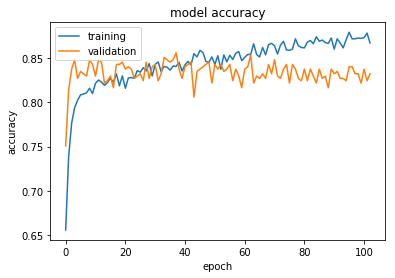

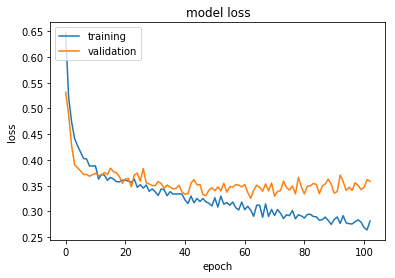

In [95]:
history_pe = LossHistory()
es_pe = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss_pe = model.fit(X_train_p, y_train_p, epochs=150, batch_size=32,
                callbacks=[history_pe,es_pe],
                validation_data=(X_test_p,y_test_p), verbose=2)
score_pe = model.evaluate(X_test_p, y_test_p, batch_size=32)
print('loss and accuracy:: ',score_pe)

plt.plot(hiss_pe.history['acc'])
plt.plot(hiss_pe.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss_pe.history['loss'])
plt.plot(hiss_pe.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

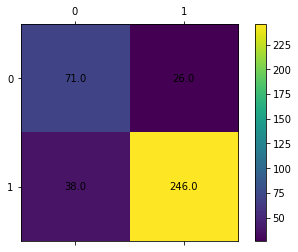

In [96]:
conf_matrix(X_test_p,y_test_p,model)

Model with K-fold Validation:
----------

Epoch 00076: early stopping
acc: 81.82%


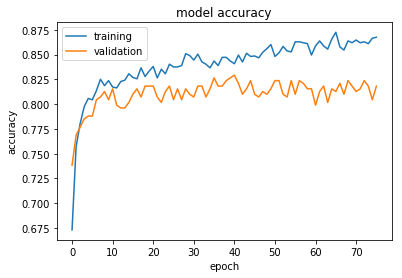

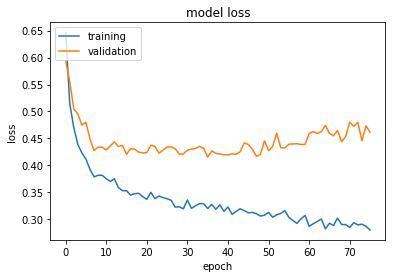

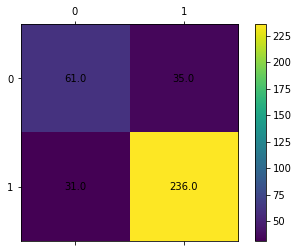

Epoch 00088: early stopping
acc: 83.70%


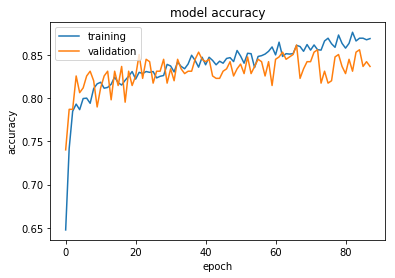

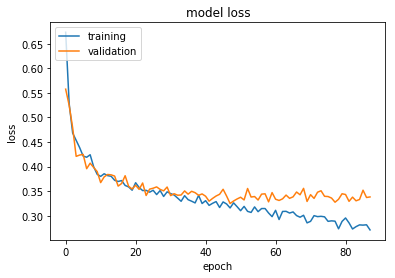

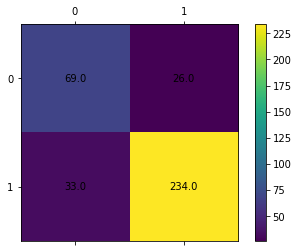

Epoch 00085: early stopping
acc: 80.39%


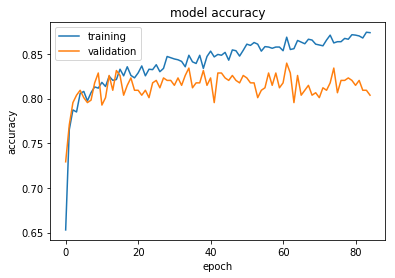

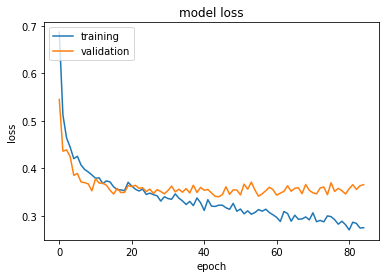

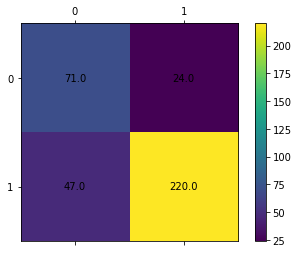

Epoch 00098: early stopping
acc: 85.36%


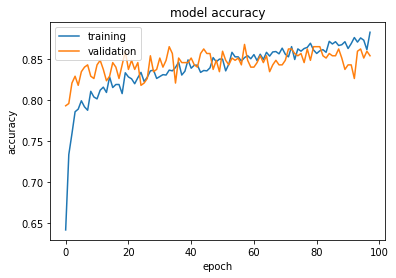

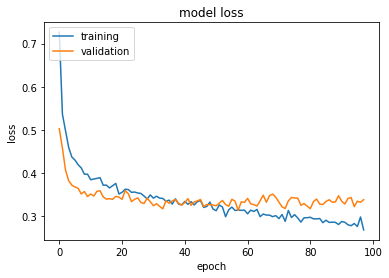

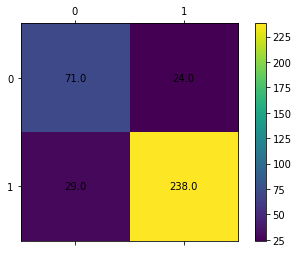

Epoch 00085: early stopping
acc: 83.70%


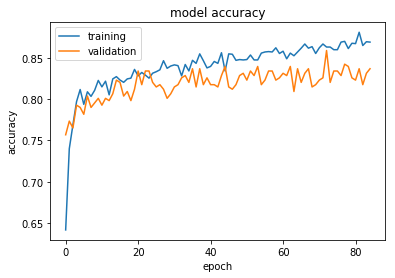

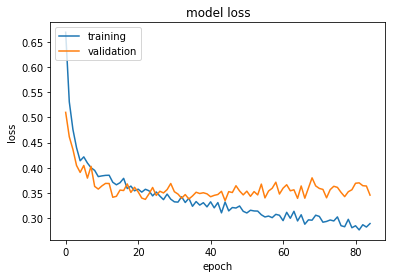

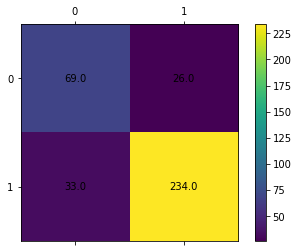

Epoch 00091: early stopping
acc: 82.32%


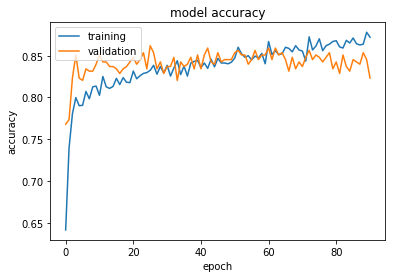

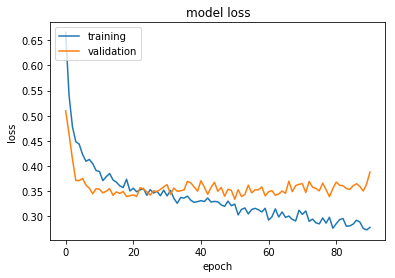

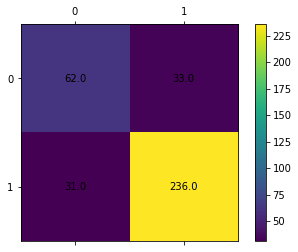

Epoch 00081: early stopping
acc: 83.43%


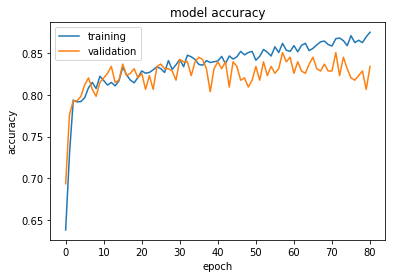

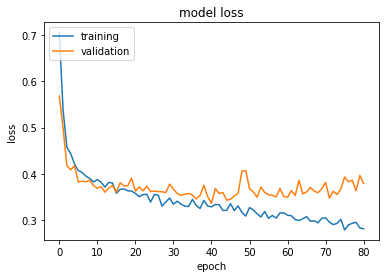

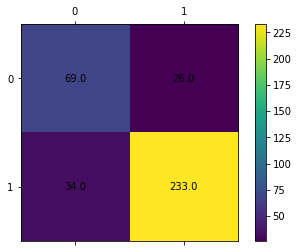

In [97]:
from sklearn.model_selection import StratifiedKFold
seed = 7
kfold_p = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores_p = []
loss_p = []
XXX = summer_pca
for train, test in kfold_s.split(XXX, y):
    
    model = init_model(features_p)
    
    X_train_kp =XXX[train].reshape(XXX[train].shape[0], XXX[train].shape[1], 1)
    X_test_kp = XXX[test].reshape(XXX[test].shape[0], XXX[test].shape[1], 1)
    history_kp = LossHistory()
    es_kp = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
    hiss_kp = model.fit(X_train_kp, y[train], epochs=150, batch_size=32,
                callbacks=[history_kp,es_kp],
                validation_data=(X_test_kp,y[test]), verbose=0)
    scores_kp = model.evaluate(X_test_kp, y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores_kp[1]*100))
    cvscores_p.append(scores_kp[1] * 100)
    loss_p.append(scores_kp[0])
#     print(score)
    plt.plot(hiss_kp.history['acc'])
    plt.plot(hiss_kp.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(hiss_kp.history['loss'])
    plt.plot(hiss_kp.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    conf_matrix(X_test_kp,y[test],model)


In [98]:
print('accuracy:: ',"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_p), np.std(cvscores_p)))
print('error::', "%.2f (+/- %.2f)" % (np.mean(loss_p), np.std(loss_p)))

accuracy::  82.96% (+/- 1.48%)
error:: 0.37 (+/- 0.04)
